In [190]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

In [191]:
data_path = "DATA/"
daily_file_names = dict(
    mex="Mex_daily_edac.txt",
    ros_nac="Nac_daily_edac.txt",
    ros_ndm="Ndm_daily_edac.txt",
)
offset_file_names = dict(
    mex="MeX_EDAC_offset.txt",
    ros_nac="Ros_AOCS_NAC_offset.txt",
    ros_ndm="Ros_AOCS_NDM_offset.txt",
    vex_ndm="VEX_NDMW0D0A_2023_01_11_12_55_55.900.txt"
)

## Load the data

In [192]:
def load_data(file_path: str):
    df = pd.read_csv(file_path, sep='\t', header=0 if 'VEX' in file_path else None)
    df.columns = ['date', 'value']
    df['date'] = pd.to_datetime(df['date'], format='mixed')
    df = df.set_index('date')
    df.sort_index(inplace=True)
    return df

daily_data = {name:load_data(data_path+file_name) for name, file_name in daily_file_names.items()}
offset_data = {name:load_data(data_path+file_name) for name, file_name in offset_file_names.items()}

## Process the offset and daily data

In [193]:
daily_data['vex_ndm'] = offset_data['vex_ndm'].resample('D').max()
for name, df in daily_data.items():
    daily_data[name] = df.resample('D').mean()

## Pot the daily data

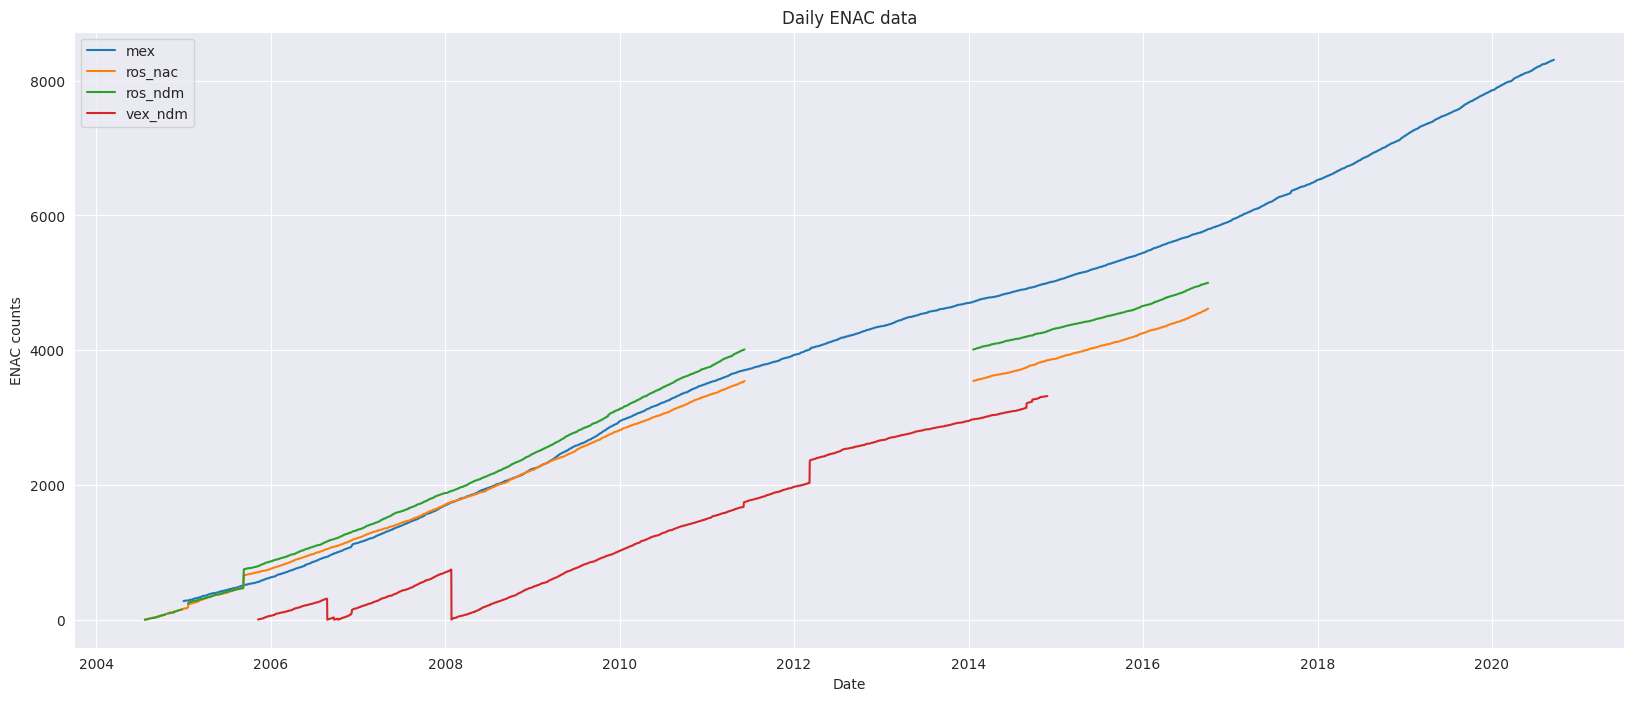

In [194]:
fig, ax = plt.subplots(figsize=(20, 8))
for name, df in daily_data.items():
    ax.plot(df, label=name)
    ax.legend()
ax.set_title("Daily ENAC data")
ax.set_ylabel("ENAC counts")
ax.set_xlabel("Date")
plt.show()

## Frequency of the offset data

In [195]:
df_frequencies = pd.DataFrame({name:[df.index.to_series().diff().median()] for name, df in offset_data.items()})
df_frequencies = df_frequencies.map(lambda x: x.total_seconds())
print("Frequency of data in seconds")
print(df_frequencies.iloc[0])

Frequency of data in seconds
mex          32.000
ros_nac     512.000
ros_ndm    1023.999
vex_ndm      64.000
Name: 0, dtype: float64


In [196]:
def get_linear_fit(data: pd.DataFrame):
    x = np.arange(len(data))
    y = data.values.reshape(-1)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, intercept, r_value, p_value, std_err

## What is the difference between the NDM and NAC data?

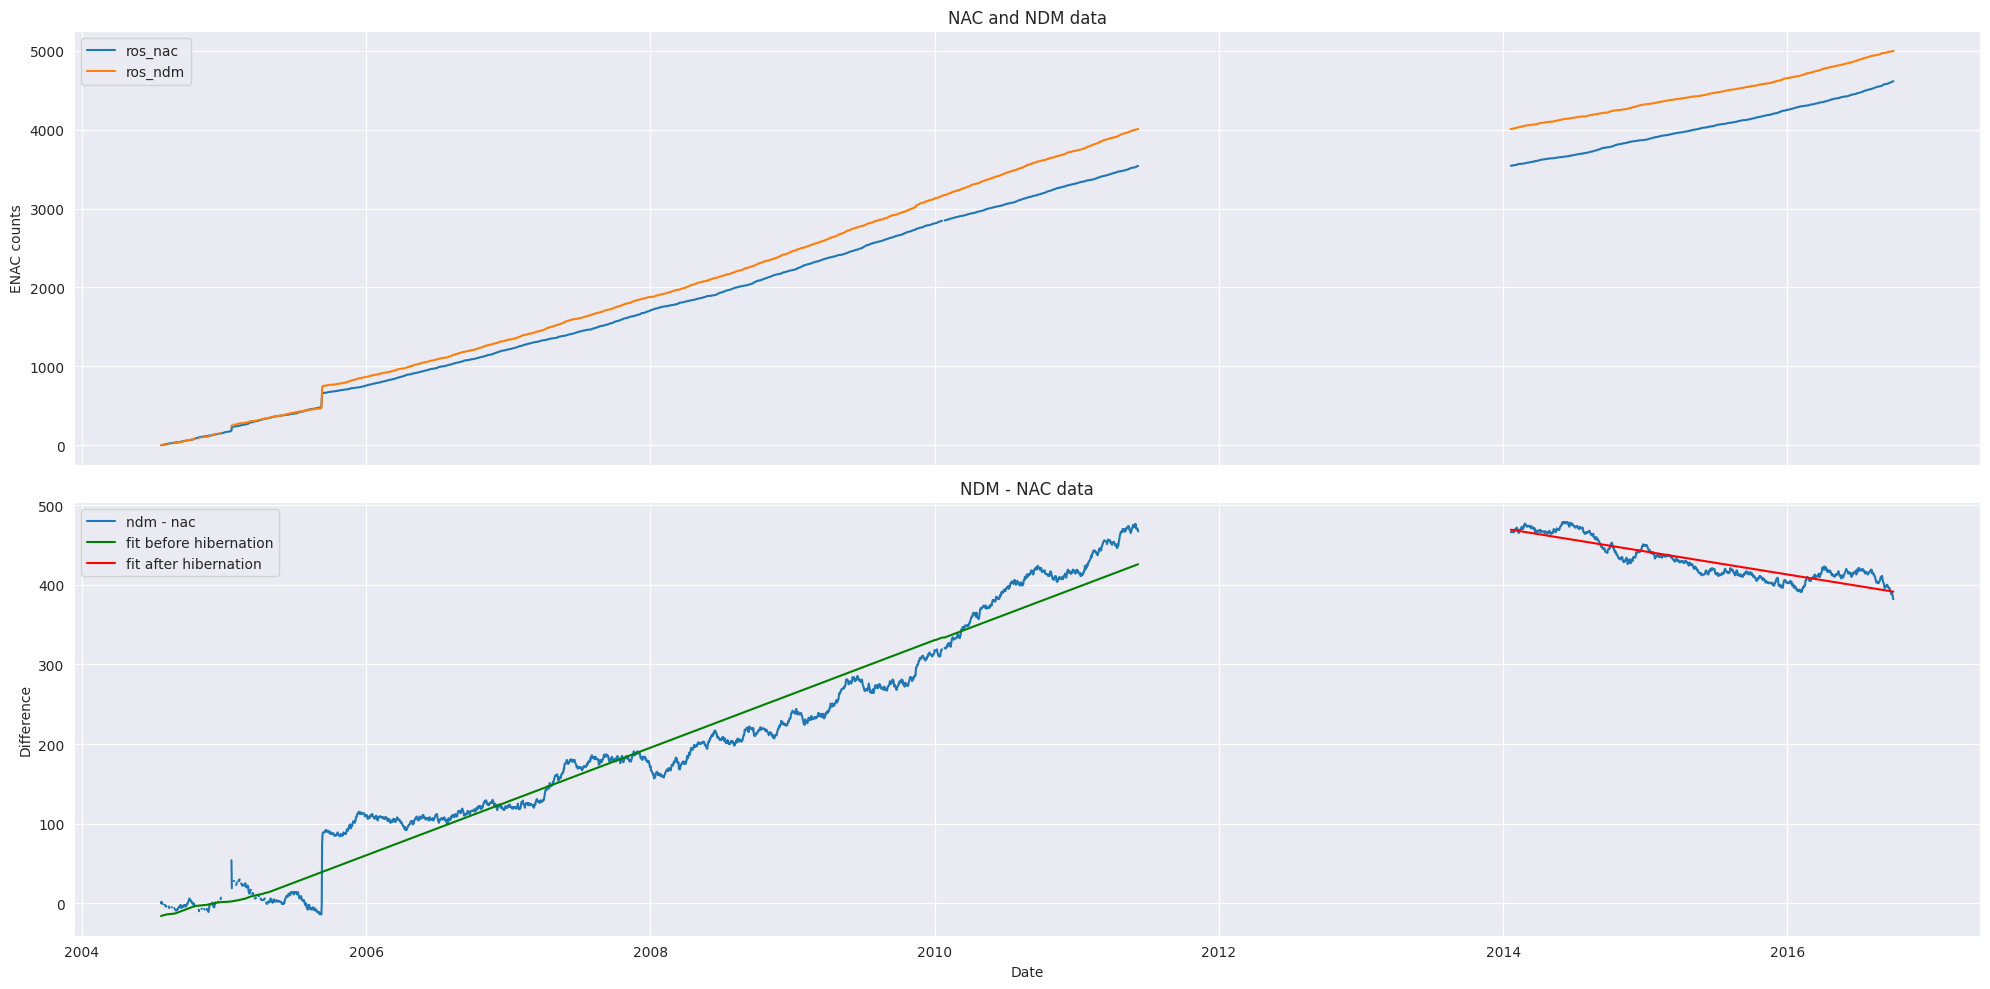

In [200]:
# Plot the difference between the ndm and nac data
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(daily_data['ros_nac'], label='ros_nac')
ax[0].plot(daily_data['ros_ndm'], label='ros_ndm')
ax[0].legend()
ax[0].set_title("NAC and NDM data")
ax[0].set_ylabel("ENAC counts")

ax[1].plot(daily_data['ros_ndm'] - daily_data['ros_nac'], label='ndm - nac')
ax[1].set_title("NDM - NAC data")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Difference")

# Linear fit the difference between the ndm and nac data
diff = daily_data['ros_ndm'] - daily_data['ros_nac']
diff_bhib = diff.loc[:'2012'].dropna()
diff_ahib = diff.loc['2014':].dropna()

slope1, intercept1, _, _, _ = get_linear_fit(diff_bhib)
slope2, intercept2, _, _, _ = get_linear_fit(diff_ahib)

# Plot the linear fit
ax[1].plot(diff_bhib.index, intercept1 + slope1 * np.arange(len(diff_bhib)), label='fit before hibernation', color='green')
ax[1].plot(diff_ahib.index, intercept2 + slope2 * np.arange(len(diff_ahib)), label='fit after hibernation', color='red')
ax[1].legend()
plt.tight_layout()
plt.show()